# Project Deliverable 3: Classification, Clustering, and Pattern Mining

- **Course:** Advanced Big Data & Data Mining
- **Student:** Nicolas Ferradas

## Environment Setup

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from mlxtend.frequent_patterns import apriori, association_rules

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)


## Load Data

In [7]:
DATA_PATH = "student_performance.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


## Create Classification Target
For this part, I will treat the G3, which is the final grade, as pass or fail based on a rule.
- For simplicity, anything over 12 will be considered as pass
- For classification I convert the numeric final grade G3 into a binary label `pass_binary`.  
- Students with G3 greater or equal to 12 are labeled as pass (1).  
- The rest are labeled as fail (0).  
- This lets me use standard classifiers and interpret results with a confusion matrix and ROC curve.

In [8]:
df['pass_binary'] = (df['G3'] >= 12).astype(int)

df['pass_binary'].value_counts(normalize=True)

pass_binary
1    0.53621
0    0.46379
Name: proportion, dtype: float64

## Build Feature Matrix and Preprocessing
The goal for this is to use all the features except the G3 and the newly created label.
- Here I am differentiating between Numeric features and categorical.

In [9]:
target_col = 'pass_binary'
drop_cols = ['G3', target_col]

X = df.drop(columns=drop_cols)
y = df[target_col]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols),('cat', categorical_transformer, categorical_cols)],remainder='drop')

Numeric features: 15
Categorical features: 17


## Build Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (519, 32) Test size: (130, 32)


## Classification models anbd evaluation Helpers
Here I will build a decision tree with hyperparameter tuning and KNN. To do this, I first need to define an evaluation helper which will aid in the tree construction.

In [11]:
def evaluate_classifier(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 score: {f1:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Fail","Pass"])
    ax.set_yticklabels(["Fail","Pass"])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return acc, f1

## Decision Tree
- As mentioned before, I will use hyperparameter tuning with GridSearchCV

Best parameters for Decision Tree: {'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best CV F1: 0.9405582797677455
Model: Decision Tree (tuned)
Accuracy: 0.915
F1 score: 0.916

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91        60
           1       0.98      0.86      0.92        70

    accuracy                           0.92       130
   macro avg       0.92      0.92      0.92       130
weighted avg       0.92      0.92      0.92       130



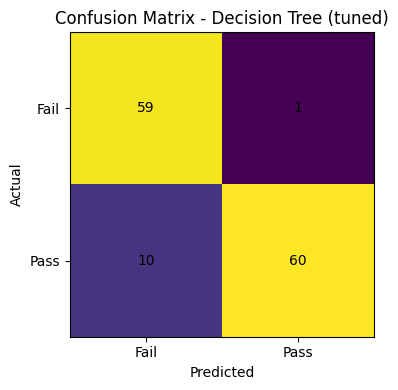

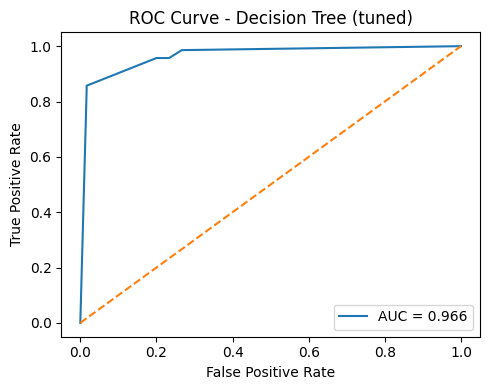

In [12]:
dt_clf = Pipeline(steps=[('pre', preprocessor),('model', DecisionTreeClassifier(random_state=42))])

param_grid = {'model__max_depth': [3, 5, 7, 10, None], 'model__min_samples_split': [2, 5, 10],'model__min_samples_leaf': [1, 2, 4]}

grid_dt = GridSearchCV(dt_clf,param_grid=param_grid, cv=5,scoring='f1',n_jobs=-1)

grid_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best CV F1:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

dt_acc, dt_f1 = evaluate_classifier("Decision Tree (tuned)", best_dt, X_train, y_train, X_test, y_test)

### Decision Tree Analysis
The tuned Decision Tree actually performed really well. With the best parameters from GridSearch, it hit about 91.5% accuracy and an F1-score of 0.916, which means it’s doing a solid job predicting who passes and who fails.

From the confusion matrix, you can see it barely misclassified any failing students, with only one being wrongly categorized, and it got most passing students right too, with just 10 mistakes. So overall, it’s much better at catching students who are at risk of failing.

The ROC curve also looks great — the AUC is 0.966, which basically means the model is very good at separating pass vs fail cases.

## K Nearest Neighbors


Model: KNN (k=5)
Accuracy: 0.815
F1 score: 0.838

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79        60
           1       0.79      0.89      0.84        70

    accuracy                           0.82       130
   macro avg       0.82      0.81      0.81       130
weighted avg       0.82      0.82      0.81       130



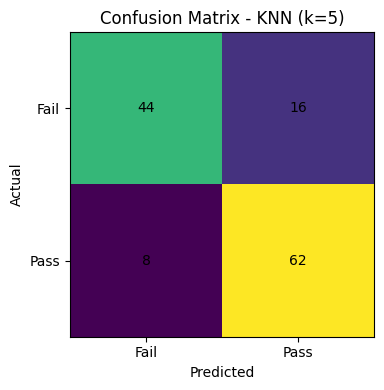

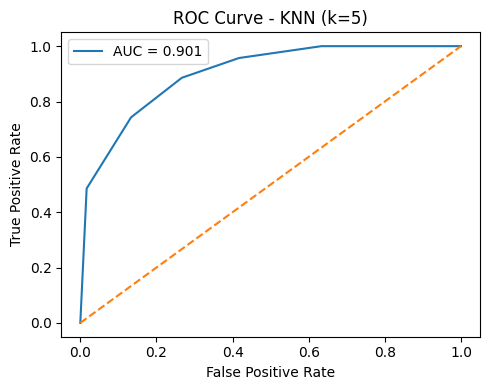

In [13]:
knn_clf = Pipeline(steps=[('pre', preprocessor),('model', KNeighborsClassifier(n_neighbors=5))])
knn_acc, knn_f1 = evaluate_classifier("KNN (k=5)", knn_clf, X_train, y_train, X_test, y_test)

### KNN Model Analisys
The KNN model performed pretty well, but not as strong as the tuned Decision Tree. It reached about 81.5% accuracy and an F1-score of 0.838, so it’s still doing a decent job separating passing and failing students.

From the confusion matrix, you can see that KNN correctly identified 44 out of 60 failing students, but it missed 16 of them. For passing students, it did better, correctly predicting 62 out of 70, with only 8 mistakes. Overall, it tends to struggle more with identifying students who are likely to fail, which is pretty common for KNN depending on how the data clusters.

The ROC curve shows an AUC of 0.901, which is still very good. It means the model is fairly strong at distinguishing between pass and fail, just not quite as sharp as the Decision Tree, which had AUC 0.966.

## Comparing Classification Models

In [15]:
results_clf = pd.DataFrame({"model": ["Decision Tree", "KNN"],"accuracy": [dt_acc, knn_acc],"f1": [dt_f1, knn_f1]})
results_clf

,model,accuracy,f1
0,Decision Tree,0.915385,0.916031
1,KNN,0.815385,0.837838


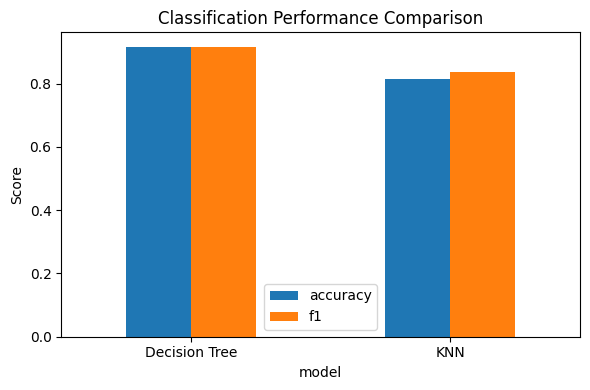

In [16]:
ax = results_clf.set_index("model")[["accuracy","f1"]].plot(
    kind="bar", figsize=(6,4), rot=0
)
ax.set_title("Classification Performance Comparison")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

### Analysis
As mentioned before, both models performed well, with the Decision tree performing slightly better than the KNN.

## Clustering with KMeans
- Here I will cluster students based on behavior and performance. That means that I will not be taking all the features, but rather just behavioral features for this analysis.

In [17]:
cluster_features = ['studytime', 'goout', 'Dalc', 'Walc', 'absences', 'G3']
cluster_df = df[cluster_features].copy()

cluster_df.head()

,studytime,goout,Dalc,Walc,absences,G3
0,2,4,1,1,4,11
1,2,3,1,1,2,11
2,2,2,2,3,6,12
3,3,2,1,1,0,14
4,2,2,1,2,0,13


In [18]:
scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_df)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_scaled)

df['cluster_k3'] = cluster_labels
df['cluster_k3'].value_counts()

cluster_k3
0    275
1    236
2    138
Name: count, dtype: int64

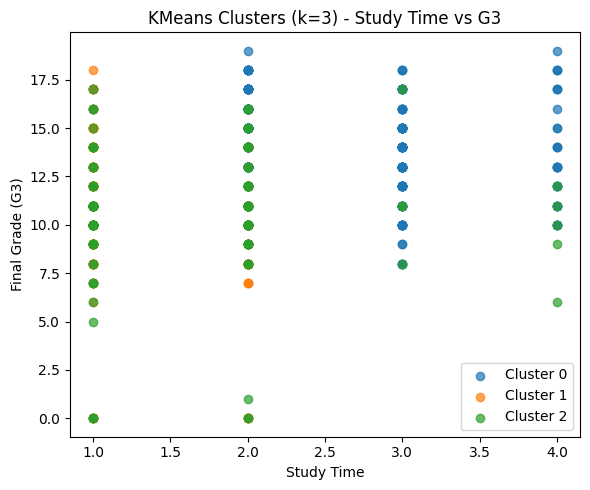

In [19]:
plt.figure(figsize=(6,5))
for label in sorted(df['cluster_k3'].unique()):
    subset = df[df['cluster_k3'] == label]
    plt.scatter(subset['studytime'], subset['G3'], label=f"Cluster {label}", alpha=0.7)

plt.xlabel("Study Time")
plt.ylabel("Final Grade (G3)")
plt.title("KMeans Clusters (k=3) - Study Time vs G3")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
df.groupby('cluster_k3')[cluster_features].mean().round(2)

,studytime,goout,Dalc,Walc,absences,G3
cluster_k3,,,,,,
0,2.54,2.88,1.15,1.69,2.06,13.88
1,1.41,3.06,1.12,1.94,4.22,10.43
2,1.61,4.01,2.85,4.04,5.88,10.50


### Analysis
**Cluster 0 (blue)**:
- These students tend to have higher study time and generally higher final grades. This group looks like the strong-performing, more disciplined students.

**Cluster 1 (green)**:
- This group is more middle-of-the-pack. Their study time varies, and their grades also span a wide range, but they are not as concentrated at the top as Cluster 0.

**Cluster 2 (orange)**:
- This cluster includes more lower-performing students. Many of the points are on the lower end of G3, and study time is usually lower too. However they do show some points nwith low study time and high grades. But that is one example of what would be an outlier

## Association Rule Mining
The objective here is to create a simple, transactional-style dataset by converting some columns into binary indicators

Some examples are:
- high_absences: absences >= 10
- high_alcohol: total_alc >= 6
- high_performance: G3 >= 15
- wants_higher_edu: higher == "yes"

In [21]:
rules_df = pd.DataFrame(index=df.index)

rules_df['high_performance'] = (df['G3'] >= 15).astype(int)
rules_df['high_absences'] = (df['absences'] >= 10).astype(int)
rules_df['high_alcohol'] = ((df['Dalc'] + df['Walc']) >= 6).astype(int)
rules_df['wants_higher_edu'] = (df['higher'] == 'yes').astype(int)
rules_df['school_GP'] = (df['school'] == 'GP').astype(int)
rules_df['school_MS'] = (df['school'] == 'MS').astype(int)
rules_df['romantic_yes'] = (df['romantic'] == 'yes').astype(int)

rules_df.head()

,high_performance,high_absences,high_alcohol,wants_higher_edu,school_GP,school_MS,romantic_yes
0,0,0,0,1,1,0,0
1,0,0,0,1,1,0,0
2,0,0,0,1,1,0,0
3,0,0,0,1,1,0,1
4,0,0,0,1,1,0,0


### Applying Apriori

In [23]:
frequent_itemsets = apriori(rules_df.astype(bool), min_support=0.05,use_colnames=True)
print("Number of itemsets found:", len(frequent_itemsets))
frequent_itemsets.head()

Number of itemsets found: 30


,support,itemsets
0,0.201849,(high_performance)
1,0.107858,(high_absences)
2,0.184900,(high_alcohol)
3,0.893683,(wants_higher_edu)
4,0.651772,(school_GP)


### Applying Association Rules

In [24]:
rules = association_rules(frequent_itemsets,metric="lift", min_threshold=1.0).sort_values("lift", ascending=False)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
32,(school_GP),"(wants_higher_edu, high_absences)",0.651772,0.081664,0.073960,0.113475,1.389536,1.0,0.020734,1.035883,0.805033,0.112150,0.034640,0.509568
31,"(wants_higher_edu, high_absences)",(school_GP),0.081664,0.651772,0.073960,0.905660,1.389536,1.0,0.020734,3.691217,0.305264,0.112150,0.729087,0.509568
44,"(school_GP, wants_higher_edu, romantic_yes)",(high_performance),0.201849,0.201849,0.055470,0.274809,1.361459,1.0,0.014727,1.100608,0.332636,0.159292,0.091411,0.274809
51,(high_performance),"(school_GP, wants_higher_edu, romantic_yes)",0.201849,0.201849,0.055470,0.274809,1.361459,1.0,0.014727,1.100608,0.332636,0.159292,0.091411,0.274809
6,(school_GP),(high_absences),0.651772,0.107858,0.095532,0.146572,1.358933,1.0,0.025233,1.045363,0.758493,0.143852,0.043394,0.516143
7,(high_absences),(school_GP),0.107858,0.651772,0.095532,0.885714,1.358933,1.0,0.025233,3.046995,0.296061,0.143852,0.671808,0.516143
16,"(school_GP, wants_higher_edu)",(high_performance),0.602465,0.201849,0.154083,0.255754,1.267058,1.0,0.032476,1.072430,0.530194,0.236967,0.067538,0.509557
17,(high_performance),"(school_GP, wants_higher_edu)",0.201849,0.602465,0.154083,0.763359,1.267058,1.0,0.032476,1.679905,0.264073,0.236967,0.404728,0.509557
46,"(high_performance, wants_higher_edu)","(school_GP, romantic_yes)",0.201849,0.223421,0.055470,0.274809,1.230008,1.0,0.010373,1.070862,0.234288,0.150000,0.066173,0.261543
27,"(school_GP, romantic_yes)",(high_performance),0.223421,0.201849,0.055470,0.248276,1.230008,1.0,0.010373,1.061761,0.240796,0.150000,0.058168,0.261543


#### Applying Filters
I will now filter some interesting rules where the consequent is high performance, to see the most affecting factors on high performance.

In [25]:
rules_high_perf = rules[rules['consequents'].astype(str).str.contains('high_performance')]
rules_high_perf.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
44,"(school_GP, wants_higher_edu, romantic_yes)",(high_performance),0.201849,0.201849,0.055470,0.274809,1.361459,1.0,0.014727,1.100608,0.332636,0.159292,0.091411,0.274809
16,"(school_GP, wants_higher_edu)",(high_performance),0.602465,0.201849,0.154083,0.255754,1.267058,1.0,0.032476,1.072430,0.530194,0.236967,0.067538,0.509557
27,"(school_GP, romantic_yes)",(high_performance),0.223421,0.201849,0.055470,0.248276,1.230008,1.0,0.010373,1.061761,0.240796,0.150000,0.058168,0.261543
49,"(school_GP, romantic_yes)","(high_performance, wants_higher_edu)",0.223421,0.201849,0.055470,0.248276,1.230008,1.0,0.010373,1.061761,0.240796,0.150000,0.058168,0.261543
48,"(school_GP, wants_higher_edu)","(high_performance, romantic_yes)",0.602465,0.075501,0.055470,0.092072,1.219479,1.0,0.009983,1.018251,0.452735,0.089109,0.017924,0.413383
22,"(romantic_yes, wants_higher_edu)",(high_performance),0.314330,0.201849,0.075501,0.240196,1.189979,1.0,0.012054,1.050470,0.232837,0.171329,0.048045,0.307121
18,(school_GP),"(high_performance, wants_higher_edu)",0.651772,0.201849,0.154083,0.236407,1.171205,1.0,0.022524,1.045257,0.419779,0.220264,0.043297,0.499883
3,(school_GP),(high_performance),0.651772,0.201849,0.154083,0.236407,1.171205,1.0,0.022524,1.045257,0.419779,0.220264,0.043297,0.499883
50,"(romantic_yes, wants_higher_edu)","(high_performance, school_GP)",0.314330,0.154083,0.055470,0.176471,1.145294,1.0,0.007037,1.027185,0.185019,0.134328,0.026465,0.268235
52,(school_GP),"(high_performance, romantic_yes, wants_higher_...",0.651772,0.075501,0.055470,0.085106,1.127225,1.0,0.006261,1.010499,0.324115,0.082569,0.010390,0.409900


### Analysis
These rules are all filtered so that the consequent is high performance, meaning that I am using the model to try to identify what combinations of behaviors or characteristics are most commonly associated with strong academic outcomes. Even though the support and confidence values aren’t extremely high, there are still some meaningful patterns.

One of the most consistent signals across the rules is school_GP. Students from the GP school appear in almost every antecedent, which tells me that GP students tend to have a higher chance of being in the high-performance group compared to MS students. Another strong factor is wants_higher_edu, as students who plan to pursue higher education are more likely to perform well academically. The presence of romantic_yes in some rules is interesting, as the model picks up a weak relationship, but based on the low support, this pattern shouldn't be overinterpreted. It basically just shows that in a small subset of students, being in a relationship doesn’t necessarily pull their grades down.

The lift values (around 1.17 to 1.36 in the strongest rules) indicate that these combinations increase the likelihood of high performance relative to chance but aren’t overwhelmingly strong. A lift above 1 means the association is meaningful, just not extremely strong. Still, these rules point toward the same general takeaway: students who are motivated and who attend the GP school show a noticeable pattern of better academic outcomes.